In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np

the above code is for fetcing the mnist data

neating out the images given

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
X,y=mnist['data'],mnist['target']
X.shape



(70000, 784)

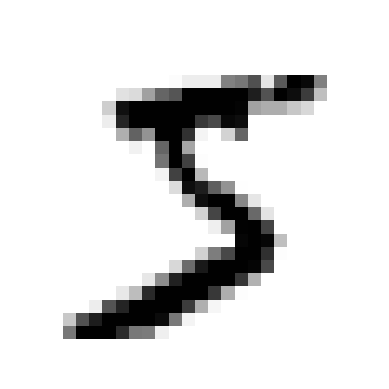

In [6]:
import matplotlib as mpl

rand_digit=X.iloc[0].to_numpy()
rand_digit_img=rand_digit.reshape(28,28)
plt.imshow(rand_digit_img,cmap='binary')
plt.axis('off')
plt.show()




In [7]:
y = y.astype(np.uint8)


the code now is for spliting the data of mnist into a test and train set where the first 60,000 images are for training and the next 10,000 are for testing,
now its already shuffled which is good, but may not be good for time based data

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

FORMATION OF A BINARY CLASSIFIER (to test if a given digit is a 5 or not-5 (but for any value, here its 5))

In [9]:
y_train_5=(y_train==5) # true if 5 else false , based on the label
y_test_5=(y_test==5)

# using a stochastic gradient descent classifier as it handles large data sets

from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=420)
sgd_clf.fit(X_train,y_train_5)

sgd_clf.predict([rand_digit])

/Users/adithyashetty/Desktop/MNST/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

using a more controlled version for the cross validation (where we controll the number of folds) , this is to just see the accuracy of it
via stratified k fold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495 (results here vary because of the seed i used)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")


array([0.9694 , 0.96545, 0.95465])

In [ ]:
from sklearn.base import BaseEstimator

class Never5(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

never_5_clf = Never5()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

the above never 5 classifier has an accuracy above 90 percent , this is because about 10 percent of the data set of mnist is 5. to show a better accuracy for this and other skewed datasets we use a CONFUSION MATRIX

In [ ]:
# building a confusion matrix

from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)



array([[53141,  1438],
       [  772,  4649]])

the confusion matrix sorts the predictions into 4 catagories:
1. True negative- values which arent 5 classified as not 5
2. False positive - values that arent 5 classifiead as 5
3. False negative - values that are 5 classified as not 5
4. True positive - values that are 5 classified as 5

then we can calculate recall and precision via :
precision=TP/TP+FP
recall=TP/TP+TN

In [ ]:
from sklearn.metrics import recall_score,precision_score
precision_score(y_train_5,y_train_pred)


0.7637588302940693

In [ ]:
recall_score(y_train_5,y_train_pred)

0.8575908503966058

to get a harmonic function of both recall and precision via F1 score which essential gives more value to low values.
formula for F1=TP/(TP +(FN+FP)/2)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.8079596802224539

decisding the threshold for precision vs recall trade off

In [ ]:
y_scores=sgd_clf.decision_function([rand_digit])
y_scores


/Users/adithyashetty/Desktop/MNST/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([731.87680986])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

to decised which threshold to use, using cross val _pred

In [ ]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions,recall,thresholds=precision_recall_curve(y_train_5,y_scores)

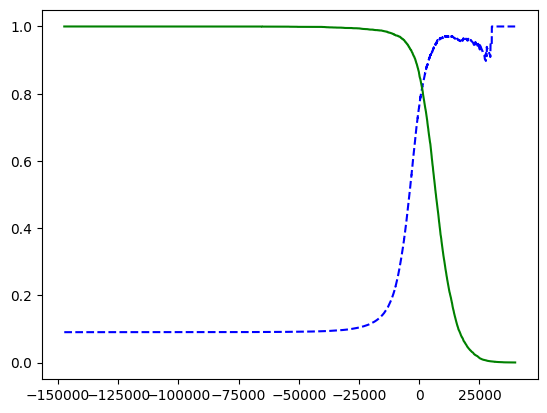

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid
plot_precision_recall_vs_threshold(precisions, recall, thresholds)
plt.show()

In [ ]:
threshold_pred_90=thresholds[np.argmax(precisions>=0.90)]
y_train_pred=(y_scores>=threshold_pred_90)


In [ ]:
precision_score(y_train_5, y_train_pred)

0.9001212121212121

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6849289798930087

GENERATING ROC GRAPH

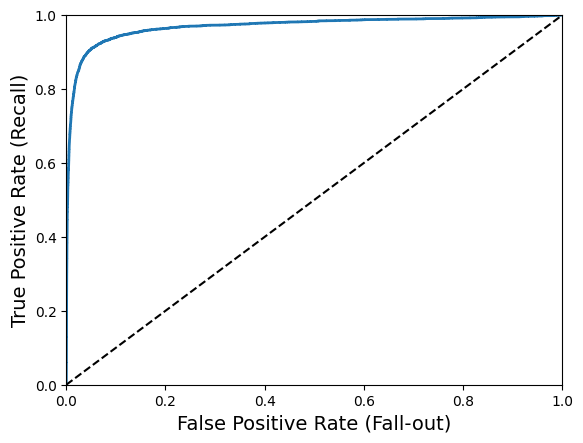

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1]) # x and y axis range
    plt.xlabel('False Positive Rate (Fall-out)')
    plt.ylabel('True Positive Rate (Recall)')

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9698204220281057

MULTICLASSIFICATION
the work done so far was just to emulate if the current image was a 5 or  not,we need a multiclassifier to actually segregate the different  numbers from 0-9
-> SGD, random forest and such can handle multiple classes 
   where as SVM and logistical regression is purely onary classifier